In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as mt
import os
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib
matplotlib.rc('figure', figsize=[10,5])

In [3]:
''' "extract_frequency_wise" function is used to extract the words along with there
    frequency from the single data file
    after removing all special characters, spaces, stopwords and every useless
    chars
    
    Parameters
    ----------
    data: file from which to be extracted
    
    Returns
    -------
    vocab_dict: dicitionary of words with frequency
'''

def extract_frequency_wise(data):
    documents = []
    
    ''' Removing Remove all the special characters, all single character,
        starting with single character,
        multiple spaces
        with only one single space
    '''
    
    for x in range(0, len(data)):  
        document = re.sub(r'\W', ' ', str(data[x]))
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        document = re.sub(r'^[a-zA-Z]\s+', ' ', document) 
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        document = document.lower()
        document = document.split()
        documents.append(document)
        
    ''' Removing stopwords and numbers '''
    
    vocab = []
    stop_words = stopwords.words('english')
    
    for i in range(len(documents)):
        for j in range(len(documents[i])):
            if not documents[i][j].isdigit() and documents[i][j] not in stop_words:
                vocab.append(documents[i][j])
    
    ''' creating frequency list '''
    
    vocab_dict = {}
    for w in vocab:
        if w not in vocab_dict:
            vocab_dict[w] = 1
        else:
            vocab_dict[w] += 1
    
    return vocab_dict

In [4]:
''' "load_20news_group" function is used to load the '20 news group' data into
    python dictionary after removing special characters from each files with help of
    "extract_frequency_wise" function 
    it stores the data into dictionary with folder name (or 20 news group classes) as a "keys"
    and list of dictionary(of vocabulary) of each file from particular folder as "values"
    
    Parameters
    ----------
    data_per_group: integer, size of data(or files) to be load from each folder
    
    Results
    -------
    dictionary: dictionary of folder wise files vocabulary
'''

def load_20news_group(data_per_group = None):
    dictionary = {}
    path = os.getcwd() + '\\20_newsgroups' # folder path from current working directory
    
    
    ''' Getting Folders Names '''
    news_groups_name = os.listdir(path)
        
    ''' Getting Files Names From Each Folder'''
    files_name_dict = {}
    for folder_name in news_groups_name:
        files_name_dict[folder_name] = os.listdir(path + '\\' + folder_name) #appending file names group by folders

        
    ''' creating frequency dictionary of words '''
    for news_group in news_groups_name:
        if data_per_group == None:
            train_limit = len(files_name_dict[news_group])
        else:
            train_limit = data_per_group
        dictionary[news_group] = []
        for file_name in files_name_dict[news_group]:
            if train_limit:
                f = open(path + '\\' + news_group +'\\'+ file_name)
                file_stream = f.readlines()
                vocab = extract_frequency_wise(file_stream) # extracting words
                dictionary[news_group].append(vocab)
                f.close()
            else:
                break
                
            train_limit -= 1
            
    return dictionary

In [5]:
''' "divide_data_train_test" function is used to divide to loaded data with help of function
    "load_20news_group" into train and test data to further making the single vocabulary list
    of train data to select the features
    
    Parameters
    ----------
    data: dictionary 
    test_size: integer, size of test data
    
    Returns
    -------
    train_data: train_data dictionary
    test_data: test_data dictionary
'''

def divide_data_train_test(data, test_size = 0.25):
    train_data = {}
    test_data = {}
    
    for k in data:
        test_len = int(len(data[k]) * (1-test_size))
        train_data[k] = data[k][:test_len]
        test_data[k]  = data[k][test_len:]
        
    return train_data, test_data

In [6]:
''' "create_vocab_dict_from_train_data" function is used to make a single flat dictionary 
    from the train data for selecting features
    
    Parameters
    ----------
    train_data: dictionary
    
    Returns
    -------
    dictionary
'''
def create_vocab_dict_from_train_data(train_data):
    main_vocab = {}
    for news_grp in train_data:
        for _dict in train_data[news_grp]:
            for k in _dict:
                if k not in main_vocab:
                    main_vocab[k] = _dict[k]
                else:
                    main_vocab[k] += _dict[k]
    return dict(sorted(main_vocab.items(), key = lambda x : x[1], reverse=True))

In [7]:
''' "create_2d_array" function is used to making a 2d numpy array from the non-flat dictionary(or nested dict)
    
    Parameters
    ----------
    data: dictionary
    table_cols: selected features(or words)
    
    Returns
    -------
    2d np array
'''
def create_2d_array(data, table_cols):
    _2darray = []
    k=0
    for group_name in data.keys():
        for _dict in data[group_name]:
            curr_row = [0] * (len(table_cols) + 1) # (+ 1) because of news_group_class_name column
            curr_row[-1] = k # news_group names
            for i in range(len(table_cols)):
                if table_cols[i] in _dict:
                    curr_row[i] = _dict[table_cols[i]]
            _2darray.append(curr_row)
        k += 1
    return np.array(_2darray)

# Loading Data from hard drive (it's takes some time)

In [8]:
data = load_20news_group() # pass one integer args for size of data

## Getting all 20 classes names

In [9]:
classes_names = list(data.keys())
print('unique classes: ',len(classes_names))

unique classes:  20


## Dividing Training and Testing Data

In [10]:
''' test_data_size: must be same in both divide_data_train_test and train_test_splitting function(s) '''

test_data_size = 0.25
train_data, test_data = divide_data_train_test(data, test_data_size)
print(len(train_data[classes_names[0]]), len(test_data[classes_names[0]]))

750 250


## Creating Words Dictionary from training data for Selecting Features

In [11]:
main_vocab = create_vocab_dict_from_train_data(train_data)

In [12]:
''' Taking top 'k' words as a features '''

k = 1791
df = pd.DataFrame({'words': list(main_vocab.keys()), 'frequency': list(main_vocab.values())})
df = df.head(k)
table_cols = list(df.words.values)

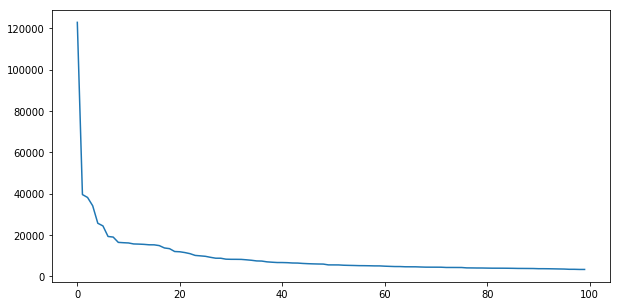

In [13]:
graph = df.head(100)
plt.plot(graph['frequency'])
plt.show()

## Creating 2d array from loaded data

In [14]:
_2darray = create_2d_array(data, table_cols)

In [15]:
_2darray.shape

(19997, 1792)

In [16]:
X = _2darray[:, :-1]#np.array(final_df.iloc[:,:-1].values, dtype='int')
Y = _2darray[:, -1]#final_df['news_group_class_name'].values
X.shape, Y.shape

((19997, 1791), (19997,))

## Splitting data into training and testing part using sklearn in built function

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_data_size, random_state=1) 
print(x_train.shape, x_test.shape)

(14997, 1791) (5000, 1791)


## Implementing `Multinomial Naive Bayes` For Text Classification

In [73]:
class MultinomialNaiveBayes:
    
    __map = {}
    __alpha = None
    
    def __init__(self, alpha):
        if alpha <= 0:
            alpha=1
        self.__alpha = alpha
    
    
    def fit(self, x_train, y_train):
        for class_type in set(y_train):
            self.__map[class_type] = {}
            xs = x_train[y_train == class_type]
            self.__map[class_type]['total_count'] = xs.sum()
            feature_counts = xs.sum(axis=0)
            self.__map[class_type]['all_features'] = feature_counts   
            
        
    def max_probability(self, x_row, classes, feature_len):
        best_class = None
        max_prob = -2**31
        for each_class in  classes:
            temp_prob = 0
            
            ''' Using numpy array for reducing time complexity '''
            
            required_features = self.__map[each_class]['all_features'][[x_row > 0]]
            log_prob = np.log(required_features + self.__alpha) - mt.log(self.__map[each_class]['total_count'] + (self.__alpha * feature_len))
            temp_prob = log_prob.sum()
            if temp_prob > max_prob:
                max_prob = temp_prob
                best_class = each_class
                
        if best_class is not None:
            return best_class
        return -1
            
    
    def predict(self, x_test):
        y_pred = []
        classes = self.__map.keys()
        feature_len = len(x_test[0])
        for x_row in x_test:
            y_pred.append(self.max_probability(x_row, classes, feature_len))
        return np.array(y_pred)
    
    
    def __str__(self):
        return('MultinomialNaiveBayes(alpha=%s)'%self.__alpha)

## Classification Using Self Implemented MultinomialNaiveBayes

In [91]:
mnb = MultinomialNaiveBayes(alpha=123)
print(mnb)
mnb.fit(x_train, y_train)

MultinomialNaiveBayes(alpha=123)


In [92]:
y_train_pred_me = mnb.predict(x_train)
y_train_pred_me

array([ 3, 15, 17, ...,  5, 12, 19])

In [93]:
y_test_pred_me = mnb.predict(x_test)
y_test_pred_me

array([14,  8,  7, ...,  7, 14,  7])

In [94]:
print(accuracy_score(y_train, y_train_pred_me))
print(accuracy_score(y_test, y_test_pred_me))
print(classification_report(y_test, y_test_pred_me))

0.9217176768687071
0.915
             precision    recall  f1-score   support

          0       0.83      0.80      0.81       261
          1       0.89      0.88      0.88       248
          2       0.92      0.92      0.92       253
          3       0.90      0.98      0.94       260
          4       0.98      0.96      0.97       266
          5       0.89      0.86      0.88       265
          6       0.94      0.95      0.95       252
          7       0.89      0.96      0.92       223
          8       1.00      0.92      0.96       293
          9       0.98      0.98      0.98       245
         10       0.99      0.98      0.98       247
         11       0.96      0.95      0.95       248
         12       0.95      0.92      0.94       239
         13       0.95      0.96      0.96       236
         14       0.95      0.97      0.96       238
         15       0.97      1.00      0.98       233
         16       0.84      0.93      0.88       255
         17       0.

###### ## Classification Using Inbuilt Sklearn MultinomialNB

In [49]:
clf = MultinomialNB()
print((clf.fit(x_train, y_train)))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [24]:
y_train_pred_naive = clf.predict(x_train)

In [25]:
y_train_pred_naive

array([ 3, 15, 17, ...,  5, 12, 19])

In [26]:
y_test_pred_naive = clf.predict(x_test)

In [27]:
y_test_pred_naive

array([14,  8,  7, ...,  4, 14,  7])

In [28]:
print(accuracy_score(y_train, y_train_pred_naive))
print(accuracy_score(y_test, y_test_pred_naive))

0.888044275521771
0.8608


## Comparision Between Two

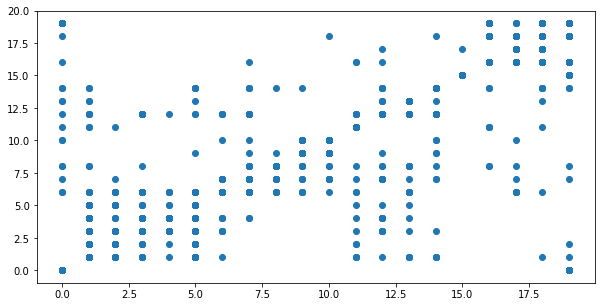

In [29]:
plt.scatter(y_test, y_test_pred_naive)
plt.show()

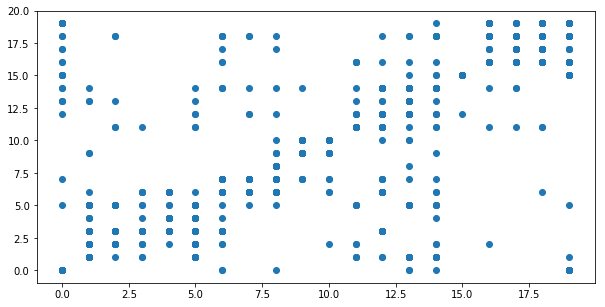

In [30]:
plt.scatter(y_train, y_train_pred_me)
plt.show()

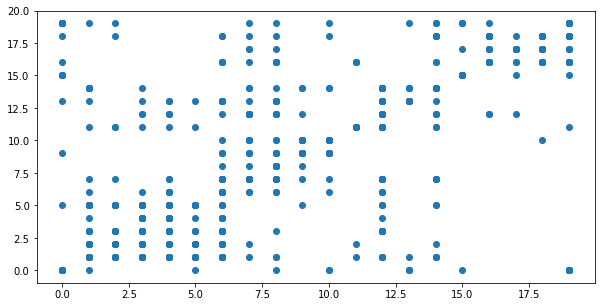

In [95]:
plt.scatter(y_test_pred_naive, y_test_pred_me)